In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
from sklearn.metrics import classification_report

In [24]:
def augment(arr):
    for idx in range(len(arr)):
        img = arr[idx]
        img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        while (img.mean() > 210) or (img.mean() < 50):
            img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        arr[idx] = img
    return arr

In [25]:
path = '../../../data/processed/color80/'
d = {}
for idx, l in enumerate(['center', 'down', 'left', 'right', 'up']):
    subpath = os.path.join(path, l)
    files = glob.glob(subpath + '/*.jpg')
    data = []
    for f in files:
        img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
        data.append(img)
    d[idx] = np.array(data)
shapes = {key:val.shape[0] for key,val in d.items()}
max_size = max(shapes.values())
print(shapes)

{0: 2776, 1: 2398, 2: 2358, 3: 2448, 4: 5272}


In [26]:
for key, val in shapes.items():
    diff = max_size - val
    if diff <= 0:
        continue
    else:
        smpl_idxs = np.random.randint(0, val-1, size=diff)
        samples = augment(d[key][smpl_idxs])
        d[key] = np.concatenate([d[key],samples])
shapes = {key:val.shape[0] for key,val in d.items()}
print(shapes)

{0: 5272, 1: 5272, 2: 5272, 3: 5272, 4: 5272}


In [27]:
images = []
labels = []
for key, val in d.items():
    images.extend(list(val))
    labels.extend([key]*len(val))
images = np.array(images)
labels = np.array(labels)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, shuffle=True, test_size=0.1, random_state=42)

In [29]:
mobile = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet',input_shape=(80,80,3))
for i in range(len(mobile.layers)):
    mobile.layers[i].trainable = False

# for i in range(-11,0):
#     mobile.layers[i].trainable = True

In [30]:
input_layer = keras.Input(shape=(80, 80, 3))
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
x = mobile(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(640, activation='relu')(x)
x = tf.keras.layers.Dense(320, activation='relu')(x)
x = tf.keras.layers.Dense(160, activation='relu')(x)
output_layer = tf.keras.layers.Dense(5, activation='softmax')(x)
model = keras.Model(inputs=input_layer, outputs=output_layer, name="mobile")

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
model.compile(optimizer=opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "mobile"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 80, 80, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 640)               819840    
_________________________________________________________________
dense_9 (Dense)              (None, 320)               20512

In [32]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint('./best_mobile.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es,mc]

In [33]:
epochs = 10

In [34]:
history = model.fit(
  x=X_train,
    y=y_train,
  epochs=epochs, 
  batch_size=128,
)

Epoch 1/10
186/186 [==============================] - 49s 253ms/step - loss: 0.6082 - accuracy: 0.7767
Epoch 2/10
186/186 [==============================] - 50s 268ms/step - loss: 0.2897 - accuracy: 0.8991
Epoch 3/10
186/186 [==============================] - 54s 293ms/step - loss: 0.2155 - accuracy: 0.9248
Epoch 4/10
186/186 [==============================] - 53s 285ms/step - loss: 0.1837 - accuracy: 0.9361
Epoch 5/10
186/186 [==============================] - 48s 256ms/step - loss: 0.1588 - accuracy: 0.9436
Epoch 6/10
186/186 [==============================] - 50s 269ms/step - loss: 0.1465 - accuracy: 0.9480
Epoch 7/10
186/186 [==============================] - 49s 266ms/step - loss: 0.1255 - accuracy: 0.9551
Epoch 8/10
186/186 [==============================] - 49s 266ms/step - loss: 0.1204 - accuracy: 0.9565
Epoch 9/10
186/186 [==============================] - 49s 265ms/step - loss: 0.1065 - accuracy: 0.9610
Epoch 10/10
186/186 [==============================] - 48s 258ms/step - l

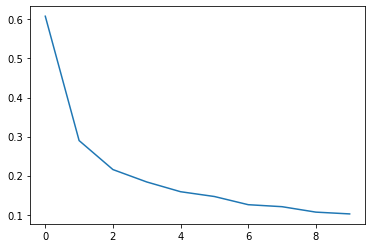

In [35]:
train_history = pd.DataFrame(history.history)
train_history.loss.plot()

In [38]:
history = model.fit(
  x=X_train,
    y=y_train,
  epochs=2, 
  batch_size=128,
)

Epoch 1/2
186/186 [==============================] - 47s 250ms/step - loss: 0.0698 - accuracy: 0.9742
Epoch 2/2
186/186 [==============================] - 46s 245ms/step - loss: 0.0690 - accuracy: 0.9737


In [39]:
model.evaluate(x=X_test, y=y_test)

83/83 [==============================] - 5s 65ms/step - loss: 0.0611 - accuracy: 0.9776


[0.061071157455444336, 0.977617621421814]

In [40]:
# model.save('./eyenet')

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./eyenet/assets


In [95]:
def augment(arr):
    for idx in range(len(arr)):
        img = arr[idx]
        img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        while (img.mean() > 210) or (img.mean() < 50):
            img = np.array(tf.image.random_brightness(img,max_delta=0.3))
        arr[idx] = img
    return arr

def load_calibration_data(path, balance:bool=True):
    d = {}
    for idx, l in enumerate(['center', 'down', 'left', 'right', 'up']):
        subpath = os.path.join(path, l)
        files = glob.glob(subpath + '/*.jpg')
        data = []
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
            data.append(img)
        d[idx] = np.array(data)
    shapes = {key:val.shape[0] for key,val in d.items()}
    max_size = max(shapes.values())
   
    if balance == True:
        for key, val in shapes.items():
            diff = max_size - val
            if diff <= 0:
                continue
            else:
                smpl_idxs = np.random.randint(0, val-1, size=diff)
                samples = augment(d[key][smpl_idxs])
                d[key] = np.concatenate([d[key],samples])
        shapes = {key:val.shape[0] for key,val in d.items()}
        
    images = []
    labels = []
    for key, val in d.items():
        images.extend(list(val))
        labels.extend([key]*len(val))
    images = np.array(images)
    labels = np.array(labels)
    print('output dataset size: ',shapes)
    return images, labels

def load_model_for_tuning(path):
    print('loading model')
    model = tf.keras.models.load_model(path)
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
    model.layers[-1].trainable = True
    return model

def tune_model(model, X, y):
    model.fit(x= X, y=y, epochs=10, batch_size =32, shuffle=True)
    return model

In [94]:
X, y = load_calibration_data('../../../data/processed/color80_test/')
eyenet = load_model_for_tuning('./eyenet/')
eyenet_tuned = tune_model(eyenet, X,y)

output dataset size:  {0: 414, 1: 414, 2: 414, 3: 414, 4: 414}
loading model
Epoch 1/10
65/65 [==============================] - 8s 72ms/step - loss: 1.0521 - accuracy: 0.7145
Epoch 2/10
65/65 [==============================] - 5s 74ms/step - loss: 0.3205 - accuracy: 0.8981
Epoch 3/10
65/65 [==============================] - 5s 78ms/step - loss: 0.2094 - accuracy: 0.9343
Epoch 4/10
65/65 [==============================] - 5s 84ms/step - loss: 0.1651 - accuracy: 0.9435
Epoch 5/10
65/65 [==============================] - 5s 82ms/step - loss: 0.1457 - accuracy: 0.9469
Epoch 6/10
65/65 [==============================] - 5s 81ms/step - loss: 0.1234 - accuracy: 0.9580
Epoch 7/10
65/65 [==============================] - 5s 76ms/step - loss: 0.1007 - accuracy: 0.9686
Epoch 8/10
65/65 [==============================] - 5s 76ms/step - loss: 0.0819 - accuracy: 0.9715
Epoch 9/10
65/65 [==============================] - 5s 79ms/step - loss: 0.0845 - accuracy: 0.9715
Epoch 10/10
65/65 [=============

In [96]:
predictions = eyenet_tuned.predict(X)
predictions =[i.argmax() for i in predictions]
report = classification_report(labels,predictions, output_dict=True)
report= pd.DataFrame(report).transpose()
scores = report['f1-score'].iloc[0:5]
scores = {int(i):j for i,j in zip(scores.index,scores.values)}
print(scores)

{0: 0.9807692307692307, 1: 0.9975903614457832, 2: 0.9987908101571946, 3: 0.9829683698296837, 4: 0.9963811821471653}


In [109]:
predictions = eyenet_tuned.predict(X)
output = [(i.argmax(),i.max()) for i in predictions]
output = pd.DataFrame(output, columns=['prediction','probability'])

In [111]:
output['true'] = y

In [133]:
output[(output.prediction==1)].true.value_counts()

1    414
0      1
4      1
Name: true, dtype: int64

In [83]:
predictions = model.predict(images)
predictions =[i.argmax() for i in predictions]
report = classification_report(labels,predictions, output_dict=True)
report= pd.DataFrame(report).transpose()
scores = report['f1-score'].iloc[0:5]
scores = {int(i):j for i,j in zip(scores.index,scores.values)}
print(scores)

{0: 0.9050410316529895, 1: 0.9390681003584229, 2: 0.974910394265233, 3: 0.9311639549436797, 4: 0.950859950859951}


In [156]:
arr = [1,5,2,3,6]

In [157]:
arr[3]+=0.5

In [158]:
model.predict()

[1, 5, 2, 3.5, 6]

In [54]:
def load_dataset(basepath):
    data = []
    labels = []
    for label in ['up','down','left','right','center']:
        files = glob.glob(os.path.join(basepath,label) + '/*.jpg')
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
            img = img.reshape((50,50,1))
#             img = np.expand_dims(img,0)
            data.append(img)
            labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    print('loading complete.')
    return data, labels

In [55]:
X, y = load_dataset(basepath='../../../data/raw/eye_frames/')

loading complete.


In [56]:
X.shape

(15252, 50, 50, 1)

In [57]:
le = preprocessing.LabelEncoder()

In [58]:
y_encoded = le.fit_transform(y)

In [59]:
le.classes_

array(['center', 'down', 'left', 'right', 'up'], dtype='<U6')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, shuffle=True)